# Домашнее задание №4

Дан датасет игроков на баскетбольном поле. Есть файл с разметкой в формате json, в котором каждый игрок на поле обведен с помощью bbox. А также определена принадлежность каждого игрока к одной из двух команд.

Что требуется сделать:
- классифицировать игроков с помощью вектора признаков игрока (features) средний цвет в пространстве RGB;
- классифицировать игроков с помощью вектора признаков игрока (features) средний цвет в пространстве HSV;
- классифицировать игроков с помощью вектора признаков игрока (features) гистограмма в пространстве RGB;
- классифицировать игроков с помощью вектора признаков игрока (features) гистограмма в пространстве HSV;

Признаки формируются из области изображения, покрытой bounding box этого игрока. Число бинов определите самостоятельно.

В качестве классификатора можете использовать (любой на выбор):
- Методы без обучения (k-means или другие методы кластеризации).
- Методы с обучением (K-Nearest Neighbors, RandomForest, GaussianNB или др.)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import optuna

from sport_team_lib import TeamDataframeMaker, TeamClassifier

## 1 Подготовка данных для обучения

### 1.1 Формирование датафрейма с признаками для обучения

Для домашней работы был реализован класс TeamDataframeMaker, который позволяет получить датафрейм со всеми требуемыми данными для обучения. Документацию можно посмотреть в файле **sport_team_lib.py**.

В датафрейме будут представлены следующие признаки:
- bbox_x1, bbox_y1, bbox_x2, bbox_y2 (денормализованные координаты бокса)
- HSV_mean_h, HSV_mean_s, HSV_mean_v (средние значения по каналам HSV для каждого бокса)
- RGB_mean_r, RGB_mean_g, RGB_mean_b (средние значения по каналам RGB для каждого бокса)
- HSV_hist_КОДКАНАЛА_НОМЕРБИНА (значения гистограммы бокса для каждого канала HSV)
- RGB_hist_КОДКАНАЛА_НОМЕРБИНА (значения гистограммы бокса для каждого канала RGB)

Дальше обучения модели можно будет оставлять только те признаки, которые требуются.

Запустим формирование датафрейма:

In [2]:
SEED = 42
bboxes_json = 'team_classification_data/bboxes.json'
image_path = 'team_classification_data/frames'

In [3]:
dataframe_maker = TeamDataframeMaker(bboxes_json=bboxes_json, image_path=image_path)
dataframe_maker.prepare_dataframe()

Выведем на печать случайную фотографию с боксами, чтобы убедиться в корректности денормализации координат боксов.
Члены разных команд будут иметь боксы раззных цветов.

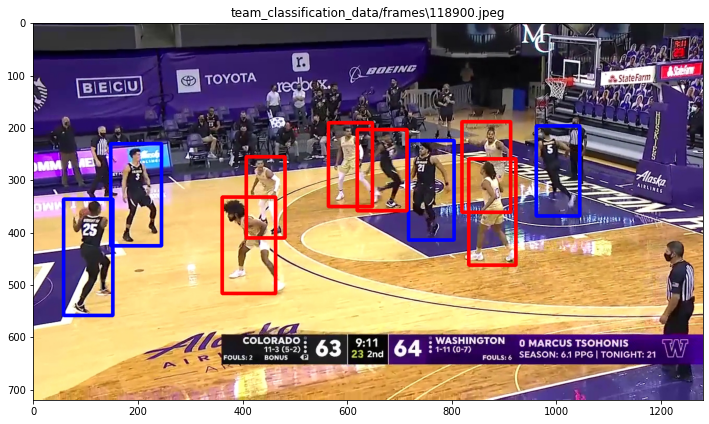

In [4]:
dataframe_maker.print_random_image()

Выведем значения датафрейма полностью:

In [5]:
dataframe_maker.df_sport_teams_

,photo,target,bbox_x1,bbox_y1,bbox_x2,bbox_y2,HSV_mean_h,HSV_mean_s,HSV_mean_v,RGB_mean_r,...,HSV_hist_v_tbin_6,HSV_hist_v_tbin_7,HSV_hist_v_tbin_8,HSV_hist_v_tbin_9,HSV_hist_v_tbin_10,HSV_hist_v_tbin_11,HSV_hist_v_tbin_12,HSV_hist_v_tbin_13,HSV_hist_v_tbin_14,HSV_hist_v_tbin_15
0,team_classification_data/frames\1310.jpeg,0,147.0,255.0,228.0,407.0,54.624024,99.345608,165.130400,161.502152,...,382.0,261.0,329.0,439.0,436.0,391.0,1088.0,3894.0,1352.0,736.0
1,team_classification_data/frames\1310.jpeg,0,871.0,313.0,1001.0,534.0,48.311395,119.726326,180.727288,163.776975,...,1334.0,1927.0,1297.0,1036.0,2037.0,4366.0,5771.0,5131.0,1563.0,2682.0
2,team_classification_data/frames\1310.jpeg,0,1126.0,244.0,1210.0,442.0,68.614780,94.580313,135.762578,129.089270,...,2156.0,1086.0,1050.0,986.0,1177.0,1401.0,1121.0,673.0,512.0,1554.0
3,team_classification_data/frames\1310.jpeg,1,621.0,276.0,712.0,484.0,58.464427,116.898325,136.730133,126.920273,...,2391.0,1114.0,747.0,700.0,1580.0,3391.0,1991.0,628.0,366.0,1126.0
4,team_classification_data/frames\1310.jpeg,0,668.0,356.0,801.0,597.0,51.483625,113.362187,184.639324,170.314173,...,897.0,1369.0,803.0,1160.0,2260.0,2917.0,5322.0,3910.0,2998.0,6865.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,team_classification_data/frames\170704.jpeg,0,384.0,266.0,486.0,385.0,49.162621,95.546845,171.137298,169.432120,...,412.0,312.0,268.0,222.0,304.0,390.0,644.0,1021.0,1712.0,3708.0
996,team_classification_data/frames\170704.jpeg,0,612.0,320.0,712.0,490.0,46.839616,113.448266,175.705576,171.014823,...,993.0,1628.0,602.0,411.0,436.0,596.0,1303.0,2468.0,1794.0,4096.0
997,team_classification_data/frames\170704.jpeg,1,681.0,333.0,787.0,516.0,55.340410,113.653291,167.059072,156.892777,...,1150.0,1085.0,655.0,640.0,686.0,794.0,1372.0,1819.0,2462.0,4380.0
998,team_classification_data/frames\170704.jpeg,1,373.0,267.0,434.0,381.0,53.137027,92.904067,152.841795,151.767461,...,282.0,213.0,223.0,173.0,216.0,261.0,299.0,345.0,865.0,1748.0


### 1.2 Проверка базовых статистик для типов признаков

Проверим базовые статистики по каждому виду признаков для каждой команды.

Здесь нужно понять есть ли различия в базовых статистиках признаков для разных команд, если различий нет, то такие признаки лучше удалить.

In [6]:
# Датафрейм для первой команды
df_team_1 = dataframe_maker.df_sport_teams_[dataframe_maker.df_sport_teams_.target == 0]
# Датафрейм для второй команды
df_team_2 = dataframe_maker.df_sport_teams_[dataframe_maker.df_sport_teams_.target == 1]

df_teams_list = [df_team_1, df_team_2]

#### 1.2.1 Проверка типа RGB_mean

In [7]:
col_type = 'RGB_mean'
for idx, df_team in enumerate(df_teams_list):
    print(f"Базовые статистики типа {col_type} для команды {idx}")
    display(df_team.loc[:, [col_type in colname for colname in dataframe_maker.df_sport_teams_.columns]].describe())

Базовые статистики типа RGB_mean для команды 0


,RGB_mean_r,RGB_mean_g,RGB_mean_b
count,502.000000,502.000000,502.000000
mean,155.495667,130.856073,112.375949
std,29.578723,25.779500,16.655831
min,83.052047,68.159649,64.873667
25%,134.451448,112.358946,100.843902
50%,153.574477,127.980705,112.248648
75%,174.849200,146.752857,122.571619
max,240.949526,210.759836,158.976798


Базовые статистики типа RGB_mean для команды 1


,RGB_mean_r,RGB_mean_g,RGB_mean_b
count,498.000000,498.000000,498.000000
mean,128.796935,107.778787,96.066988
std,28.166479,23.981695,16.107621
min,60.539333,55.436833,57.065046
25%,107.933279,89.717553,85.358012
50%,127.814410,105.545556,95.213956
75%,147.386317,124.295335,106.203107
max,224.235346,197.520048,153.911188


#### 1.2.2 Проверка типа HSV_mean

In [8]:
col_type = 'HSV_mean'
for idx, df_team in enumerate(df_teams_list):
    print(f"Базовые статистики типа {col_type} для команды {idx}")
    display(df_team.loc[:, [col_type in colname for colname in dataframe_maker.df_sport_teams_.columns]].describe())

Базовые статистики типа HSV_mean для команды 0


,HSV_mean_h,HSV_mean_s,HSV_mean_v
count,502.000000,502.000000,502.000000
mean,57.201962,101.874940,162.430893
std,19.249614,12.829122,27.447630
min,20.359664,69.265353,91.071637
25%,44.073746,92.658787,142.975206
50%,55.874905,101.927144,160.125472
75%,69.875072,111.000026,181.590829
max,112.157728,135.236888,240.971271


Базовые статистики типа HSV_mean для команды 1


,HSV_mean_h,HSV_mean_s,HSV_mean_v
count,498.000000,498.000000,498.000000
mean,66.421444,103.402858,136.500479
std,21.908091,14.276161,26.664636
min,19.484472,46.950459,62.271500
25%,52.035975,94.974601,117.590840
50%,64.079305,105.652270,135.789635
75%,82.048734,113.452266,154.687873
max,123.348061,134.162491,224.289251


#### 1.2.3 Проверка типа RGB_hist

In [9]:
col_type = 'RGB_hist'
for idx, df_team in enumerate(df_teams_list):
    print(f"Базовые статистики типа {col_type} для команды {idx}")
    display(df_team.loc[:, [col_type in colname for colname in dataframe_maker.df_sport_teams_.columns]].describe())

Базовые статистики типа RGB_hist для команды 0


,RGB_hist_r_bin_0,RGB_hist_r_bin_1,RGB_hist_r_bin_2,RGB_hist_r_bin_3,RGB_hist_r_bin_4,RGB_hist_r_bin_5,RGB_hist_r_bin_6,RGB_hist_r_bin_7,RGB_hist_r_bin_8,RGB_hist_r_bin_9,...,RGB_hist_b_bin_6,RGB_hist_b_bin_7,RGB_hist_b_bin_8,RGB_hist_b_bin_9,RGB_hist_b_bin_10,RGB_hist_b_bin_11,RGB_hist_b_bin_12,RGB_hist_b_bin_13,RGB_hist_b_bin_14,RGB_hist_b_bin_15
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,...,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,187.808765,657.364542,1042.595618,976.950199,1229.231076,874.187251,687.665339,641.798805,649.386454,733.067729,...,1911.404382,1937.227092,1936.103586,1370.593625,830.677291,582.041833,445.541833,362.675299,348.844622,830.697211
std,253.055356,590.031296,735.259204,579.209437,922.295469,641.562430,420.002333,362.623201,336.337426,407.702960,...,1114.553689,1258.145807,1362.448775,1183.369818,557.800410,340.475352,263.101677,233.845899,247.950988,816.606800
min,0.000000,8.000000,36.000000,70.000000,75.000000,79.000000,88.000000,123.000000,143.000000,143.000000,...,351.000000,433.000000,261.000000,187.000000,106.000000,75.000000,51.000000,21.000000,10.000000,0.000000
25%,62.000000,255.500000,525.250000,592.250000,578.750000,414.000000,392.250000,366.250000,384.250000,420.750000,...,1099.750000,1073.000000,952.500000,691.250000,481.250000,337.000000,255.000000,187.250000,166.250000,254.250000
50%,144.000000,501.000000,864.500000,867.000000,934.500000,727.000000,584.000000,579.000000,585.500000,644.000000,...,1648.000000,1707.500000,1570.000000,1019.500000,676.000000,496.500000,384.500000,310.500000,281.500000,580.000000
75%,227.750000,819.750000,1377.750000,1210.750000,1623.000000,1111.500000,904.250000,840.000000,868.000000,944.500000,...,2435.500000,2382.750000,2341.750000,1558.000000,992.500000,742.750000,598.000000,489.250000,493.250000,1131.000000
max,2871.000000,4133.000000,4890.000000,4340.000000,5047.000000,3619.000000,2632.000000,2190.000000,2083.000000,2740.000000,...,7450.000000,13219.000000,8079.000000,9974.000000,4280.000000,2392.000000,1604.000000,1535.000000,1568.000000,5955.000000


Базовые статистики типа RGB_hist для команды 1


,RGB_hist_r_bin_0,RGB_hist_r_bin_1,RGB_hist_r_bin_2,RGB_hist_r_bin_3,RGB_hist_r_bin_4,RGB_hist_r_bin_5,RGB_hist_r_bin_6,RGB_hist_r_bin_7,RGB_hist_r_bin_8,RGB_hist_r_bin_9,...,RGB_hist_b_bin_6,RGB_hist_b_bin_7,RGB_hist_b_bin_8,RGB_hist_b_bin_9,RGB_hist_b_bin_10,RGB_hist_b_bin_11,RGB_hist_b_bin_12,RGB_hist_b_bin_13,RGB_hist_b_bin_14,RGB_hist_b_bin_15
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,...,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,342.759036,1456.291165,2172.339357,1363.885542,1332.662651,956.827309,748.056225,623.544177,555.321285,560.399598,...,1707.287149,1803.383534,1640.546185,1032.700803,607.098394,427.447791,338.265060,275.345382,257.152610,644.708835
std,294.252527,1123.280766,1066.469785,717.422012,1035.042457,648.123049,389.118708,324.256095,303.701374,347.728731,...,1039.027381,1437.922442,1513.707430,995.536783,470.466843,292.915701,236.283783,211.027431,231.461312,795.347731
min,0.000000,26.000000,345.000000,342.000000,218.000000,138.000000,161.000000,165.000000,125.000000,89.000000,...,238.000000,201.000000,63.000000,21.000000,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,183.500000,730.750000,1454.500000,889.250000,666.000000,537.250000,489.250000,402.250000,333.250000,294.000000,...,921.000000,887.250000,641.750000,422.000000,295.250000,208.250000,154.000000,109.000000,76.750000,109.250000
50%,291.500000,1147.500000,1980.500000,1162.000000,983.000000,777.500000,662.500000,529.500000,498.000000,493.000000,...,1459.500000,1373.000000,1084.500000,716.000000,466.000000,353.500000,294.000000,227.500000,187.000000,347.500000
75%,424.750000,1813.750000,2672.000000,1603.500000,1637.500000,1140.500000,878.750000,772.750000,715.000000,733.750000,...,2193.750000,2198.500000,2015.000000,1198.750000,776.000000,573.500000,474.250000,383.000000,377.750000,907.750000
max,3193.000000,9827.000000,8431.000000,5250.000000,7351.000000,4160.000000,2457.000000,2722.000000,2380.000000,2206.000000,...,5982.000000,11535.000000,10523.000000,6272.000000,3918.000000,1997.000000,1708.000000,1432.000000,1490.000000,6768.000000


#### 1.2.4 Проверка типа HSV_hist

In [10]:
col_type = 'HSV_hist'
for idx, df_team in enumerate(df_teams_list):
    print(f"Базовые статистики типа {col_type} для команды {idx}")
    display(df_team.loc[:, [col_type in colname for colname in dataframe_maker.df_sport_teams_.columns]].describe())

Базовые статистики типа HSV_hist для команды 0


,HSV_hist_h_bin_0,HSV_hist_h_bin_1,HSV_hist_h_bin_2,HSV_hist_h_bin_3,HSV_hist_h_bin_4,HSV_hist_h_bin_5,HSV_hist_h_bin_6,HSV_hist_h_bin_7,HSV_hist_h_bin_8,HSV_hist_h_bin_9,...,HSV_hist_v_tbin_6,HSV_hist_v_tbin_7,HSV_hist_v_tbin_8,HSV_hist_v_tbin_9,HSV_hist_v_tbin_10,HSV_hist_v_tbin_11,HSV_hist_v_tbin_12,HSV_hist_v_tbin_13,HSV_hist_v_tbin_14,HSV_hist_v_tbin_15
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,...,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,3759.063745,8387.569721,32.868526,9.276892,15.500000,54.043825,159.868526,1293.938247,2228.671315,985.625498,...,969.346614,1064.099602,892.338645,808.041833,1007.515936,1414.647410,1700.418327,1640.733068,1394.519920,3420.862550
std,1805.260283,5509.610762,101.306567,35.577766,56.755059,164.522141,319.997016,1252.827941,1753.178394,670.110575,...,646.180706,770.322380,626.939438,459.045804,637.012992,982.044963,1215.184658,1230.875386,1235.205275,3388.552992
min,679.000000,399.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,...,86.000000,127.000000,145.000000,162.000000,134.000000,124.000000,134.000000,165.000000,49.000000,13.000000
25%,2417.500000,4296.000000,0.000000,0.000000,0.000000,0.000000,0.000000,351.500000,944.000000,544.000000,...,501.750000,489.500000,449.250000,435.250000,491.750000,681.500000,744.500000,698.500000,613.500000,1101.750000
50%,3383.000000,6954.500000,8.000000,0.000000,1.000000,3.000000,24.500000,956.500000,1760.000000,851.500000,...,791.000000,823.500000,722.000000,715.500000,871.500000,1194.500000,1434.000000,1271.500000,1006.500000,2151.500000
75%,4613.750000,11291.750000,30.000000,5.000000,8.000000,21.000000,133.750000,1791.750000,3159.250000,1278.750000,...,1266.750000,1438.250000,1150.250000,1081.000000,1343.000000,1873.500000,2302.250000,2203.000000,1777.000000,4474.500000
max,11415.000000,29651.000000,1616.000000,550.000000,634.000000,2091.000000,1945.000000,6868.000000,8364.000000,6500.000000,...,3909.000000,4833.000000,4037.000000,2857.000000,4555.000000,6976.000000,7601.000000,6313.000000,10676.000000,18798.000000


Базовые статистики типа HSV_hist для команды 1


,HSV_hist_h_bin_0,HSV_hist_h_bin_1,HSV_hist_h_bin_2,HSV_hist_h_bin_3,HSV_hist_h_bin_4,HSV_hist_h_bin_5,HSV_hist_h_bin_6,HSV_hist_h_bin_7,HSV_hist_h_bin_8,HSV_hist_h_bin_9,...,HSV_hist_v_tbin_6,HSV_hist_v_tbin_7,HSV_hist_v_tbin_8,HSV_hist_v_tbin_9,HSV_hist_v_tbin_10,HSV_hist_v_tbin_11,HSV_hist_v_tbin_12,HSV_hist_v_tbin_13,HSV_hist_v_tbin_14,HSV_hist_v_tbin_15
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,...,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,4016.158635,6700.291165,54.799197,18.678715,30.863454,60.138554,208.018072,1870.397590,2648.819277,1093.867470,...,1082.355422,1046.787149,798.313253,647.285141,742.405622,1010.172691,1200.819277,1287.769076,1220.433735,2684.240964
std,1774.021238,5193.553545,112.851837,58.785984,101.525752,183.775437,343.574033,1668.743155,2085.083686,742.940998,...,739.490460,798.011905,598.245122,415.986519,555.997955,864.062057,960.831726,1161.377858,1289.033205,3104.725828
min,718.000000,62.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,...,161.000000,165.000000,146.000000,100.000000,50.000000,13.000000,7.000000,0.000000,0.000000,0.000000
25%,2788.500000,2842.500000,3.000000,0.000000,0.000000,0.000000,10.000000,657.000000,1218.000000,623.750000,...,615.750000,524.750000,393.250000,318.250000,315.500000,362.250000,474.000000,460.000000,367.500000,641.500000
50%,3652.000000,5480.000000,19.000000,2.000000,5.000000,3.000000,64.500000,1389.000000,2027.000000,934.500000,...,844.000000,795.000000,623.500000,554.000000,561.000000,753.500000,909.500000,886.000000,725.500000,1581.000000
75%,5066.250000,8940.750000,52.000000,11.000000,20.000000,34.750000,216.250000,2449.250000,3576.500000,1326.500000,...,1276.250000,1292.250000,1010.250000,888.250000,997.750000,1337.750000,1756.000000,1717.250000,1654.250000,3568.500000
max,12909.000000,25173.000000,1255.000000,654.000000,1168.000000,2856.000000,2529.000000,8782.000000,13640.000000,6756.000000,...,5447.000000,6771.000000,4275.000000,2724.000000,3881.000000,5037.000000,4870.000000,8174.000000,8349.000000,19947.000000


Из полученных результатов видно, что базовые статистики различаются по командам и все они могут помочь при обучении модели.

## 1.3 Проверка корреляции признаков

В этом разделе посмотрим какие признаки хорошо коррелируют с целевой переменной target. Дальше при обучении можно попробовать оставить только те признаки, которые дают хорошую корреляцию.

### 1.3.1 Матрица корреляции типа признаков RGB_mean

Матрица корреляции для типа признаков RGB_mean


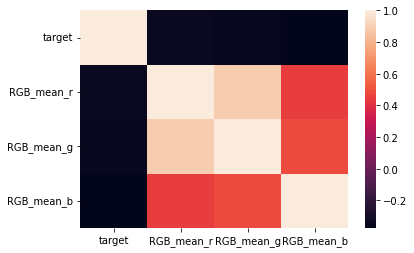

In [11]:
col_type = 'RGB_mean'
stat_col_names = [col_type in colname or colname == 'target' for colname in dataframe_maker.df_sport_teams_.columns]
print(f"Матрица корреляции для типа признаков {col_type}")
sns.heatmap(dataframe_maker.df_sport_teams_.loc[:, stat_col_names].corr(method='kendall'))
plt.show()

Из результатов матрицы корреляции средних значений по каналам RGB видно, что у признаков вообще отсутствует какая-либо корреляция. Можно сделать вывод, что эти признаки будут бесполезны для обучения модели.

### 1.3.2 Матрица корреляции типа признаков HSV_mean

Матрица корреляции для типа признаков HSV_mean


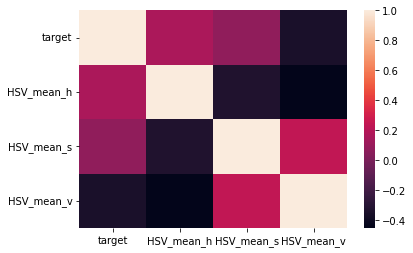

In [12]:
col_type = 'HSV_mean'
stat_col_names = [col_type in colname or colname == 'target' for colname in dataframe_maker.df_sport_teams_.columns]
print(f"Матрица корреляции для типа признаков {col_type}")
sns.heatmap(dataframe_maker.df_sport_teams_.loc[:, stat_col_names].corr(method='kendall'))
plt.show()

Из результатов матрицы корреляции средних значений по каналам HSV видно, что есть небольшая зависимость целевой переменной от Hue и Saturation, но Value не влияет никак. Его тоже можно убрать.

### 1.3.3 Матрица корреляции типа признаков RGB_hist

Матрица корреляции для типа признаков RGB_hist


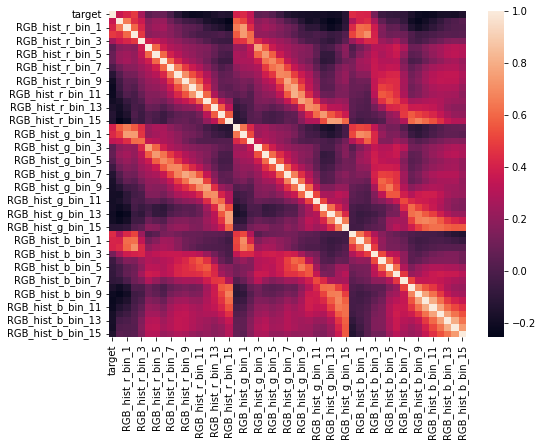

In [13]:
col_type = 'RGB_hist'
stat_col_names = [col_type in colname or colname == 'target' for colname in dataframe_maker.df_sport_teams_.columns]
print(f"Матрица корреляции для типа признаков {col_type}")
plt.figure(figsize=(8,6))
sns.heatmap(dataframe_maker.df_sport_teams_.loc[:, stat_col_names].corr(method='kendall'))
plt.show()

Из результатов матрицы корреляции значений бинов гистограммы по каналам RGB можно сделать вывод, что по каналам RGB есть зависимость от целевой переменной примерно до 8 бина. Бины больше 8 можно попробовать удалить.

### 1.3.4 Матрица корреляции типа признаков HSV_hist

Матрица корреляции для типа признаков HSV_hist


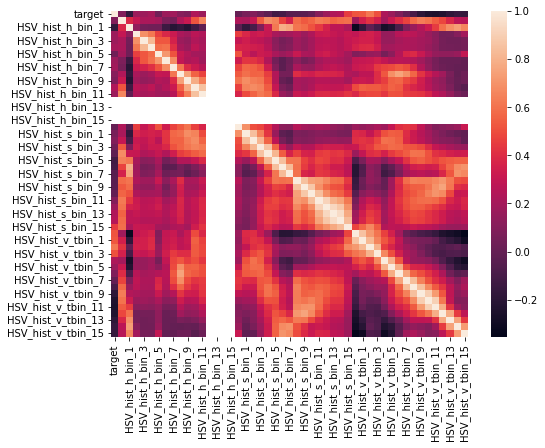

In [14]:
col_type = 'HSV_hist'
stat_col_names = [col_type in colname or colname == 'target' for colname in dataframe_maker.df_sport_teams_.columns]
print(f"Матрица корреляции для типа признаков {col_type}")
plt.figure(figsize=(8,6))
sns.heatmap(dataframe_maker.df_sport_teams_.loc[:, stat_col_names].corr(method='spearman'))
plt.show()

Из результатов матрицы корреляции значений бинов гистограммы по каналам HSV можно сделать следующие выводы:
- бины из Value менее всего коррелируют в целевой переменной, но есть хорошая корреляция в начальных бинах;
- бины saturation и hue в целом имеют небольшую корреляцию с целевой переменой

## 2 Обучение модели

Для решения задачи обучения модели был создан класс TeamClassifier.

С помощью параметра model_class можно указать какой-либо класс модели из библиотеки sklearn. Модель обучается с помощью стратифицированной кросс-валидации. Указываем необходимое количество фолдов, для каждого фолда будет создан экземпляр модели выбранного класса. И каждая модель обучится на своем фолде. Для предсказаний будет использована каждая модель и результат будет выбираться по наибольшему количеству голосов для класса.

Документацию можно посмотреть в файле **sport_team_lib.py**.

Так же для предсказания реализован метод **predict_from_json()**, в котором можно указать путь до файла с разметкой боксов и путь к папке с изображениями. Модель сама преобразует данные в требуемый формат и выдаст предсказания.

В данном разделе в качестве модели будем использовать **RandomForestClassifier**

In [15]:
team_classifier = TeamClassifier.load_from_json(bboxes_json=bboxes_json, image_path=image_path, 
                                                model_class=RandomForestClassifier,
                                                model_params={'n_estimators': 300, 
                                                              'max_depth': 20, 
                                                              'random_state': SEED,
                                                              'n_jobs': -1},
                                                folds=5,
                                                random_state=SEED)

all_fit_feature_names = team_classifier.fit_features_names

### 2.1 Модель с признаками типа RGB_mean

In [16]:
col_type = 'RGB_mean'
team_classifier.fit_features_names = [colname for colname in all_fit_feature_names if col_type in colname]
team_classifier.fit()
print("K-Fold Mean Accuracy:", round(team_classifier.train_kfold_accuracy, 4))

K-Fold Mean Accuracy: 0.699


### 2.2 Модель с признаками типа HSV_mean

In [17]:
col_type = 'HSV_mean'
team_classifier.fit_features_names = [colname for colname in all_fit_feature_names if col_type in colname]
team_classifier.fit()
print("K-Fold Mean Accuracy:", round(team_classifier.train_kfold_accuracy, 4))

K-Fold Mean Accuracy: 0.715


### 2.3 Модель с признаками типа RGB_hist

In [18]:
col_type = 'RGB_hist'
team_classifier.fit_features_names = [colname for colname in all_fit_feature_names if col_type in colname]
team_classifier.fit()
print("K-Fold Mean Accuracy:", round(team_classifier.train_kfold_accuracy, 4))

K-Fold Mean Accuracy: 0.851


### 2.4 Модель с признаками типа HSV_hist

In [19]:
col_type = 'HSV_hist'
team_classifier.fit_features_names = [colname for colname in all_fit_feature_names if col_type in colname]
team_classifier.fit()
print("K-Fold Mean Accuracy:", round(team_classifier.train_kfold_accuracy, 4))

K-Fold Mean Accuracy: 0.852


### 2.5 Модель с признаками RGB_hist и HSV_hist

In [20]:
col_type1 = 'HSV_hist'
col_type2 = 'RGB_hist'

team_classifier.fit_features_names = [colname for colname in all_fit_feature_names 
                                      if col_type1 in colname or col_type1 in col_type2]
team_classifier.fit()
print("K-Fold Mean Accuracy:", round(team_classifier.train_kfold_accuracy, 4))

K-Fold Mean Accuracy: 0.852


### 2.6 Модель со всеми признаками

In [21]:
team_classifier.fit_features_names = all_fit_feature_names
team_classifier.fit()
print("K-Fold Mean Accuracy:", round(team_classifier.train_kfold_accuracy, 4))

K-Fold Mean Accuracy: 0.854


### 2.7 Модель с удалением признаков на основе анализа корреляции

Мы получили лучший результат 0.854 при использовании всех признаков. Теперь попробуем удалить те признаки, которые посчитали ненужными в части анализа корреляции:

- удаляем все признаки типа RGB_mean;
- в типе признаков RGB_hist оставляем только бины от 0 до 8;
- в типе HSV_hist удаляем бины от 9 до 16 для канала V.

In [22]:
fit_feature_names = ['HSV_mean_h',
 'HSV_mean_s',
 'RGB_hist_r_bin_0',
 'RGB_hist_r_bin_1',
 'RGB_hist_r_bin_2',
 'RGB_hist_r_bin_3',
 'RGB_hist_r_bin_4',
 'RGB_hist_r_bin_5',
 'RGB_hist_r_bin_6',
 'RGB_hist_r_bin_7',
 'RGB_hist_r_bin_8',
 'RGB_hist_g_bin_0',
 'RGB_hist_g_bin_1',
 'RGB_hist_g_bin_2',
 'RGB_hist_g_bin_3',
 'RGB_hist_g_bin_4',
 'RGB_hist_g_bin_5',
 'RGB_hist_g_bin_6',
 'RGB_hist_g_bin_7',
 'RGB_hist_g_bin_8',
 'RGB_hist_b_bin_0',
 'RGB_hist_b_bin_1',
 'RGB_hist_b_bin_2',
 'RGB_hist_b_bin_3',
 'RGB_hist_b_bin_4',
 'RGB_hist_b_bin_5',
 'RGB_hist_b_bin_6',
 'RGB_hist_b_bin_7',
 'RGB_hist_b_bin_8',
 'HSV_hist_h_bin_1',
 'HSV_hist_h_bin_2',
 'HSV_hist_h_bin_3',
 'HSV_hist_h_bin_4',
 'HSV_hist_h_bin_5',
 'HSV_hist_h_bin_6',
 'HSV_hist_h_bin_7',
 'HSV_hist_h_bin_8',
 'HSV_hist_h_bin_9',
 'HSV_hist_h_bin_10',
 'HSV_hist_h_bin_11',
 'HSV_hist_h_bin_12',
 'HSV_hist_h_bin_13',
 'HSV_hist_h_bin_14',
 'HSV_hist_h_bin_15',
 'HSV_hist_s_bin_0',
 'HSV_hist_s_bin_1',
 'HSV_hist_s_bin_2',
 'HSV_hist_s_bin_3',
 'HSV_hist_s_bin_4',
 'HSV_hist_s_bin_5',
 'HSV_hist_s_bin_6',
 'HSV_hist_s_bin_7',
 'HSV_hist_s_bin_8',
 'HSV_hist_s_bin_9',
 'HSV_hist_s_bin_10',
 'HSV_hist_s_bin_11',
 'HSV_hist_s_bin_12',
 'HSV_hist_s_bin_13',
 'HSV_hist_s_bin_14',
 'HSV_hist_s_bin_15',
 'HSV_hist_v_tbin_0',
 'HSV_hist_v_tbin_1',
 'HSV_hist_v_tbin_2',
 'HSV_hist_v_tbin_3',
 'HSV_hist_v_tbin_4',
 'HSV_hist_v_tbin_5',
 'HSV_hist_v_tbin_6',
 'HSV_hist_v_tbin_7',
 'HSV_hist_v_tbin_8']

team_classifier.fit_features_names = fit_feature_names
team_classifier.fit()
print("K-Fold Mean Accuracy:", round(team_classifier.train_kfold_accuracy, 4))

K-Fold Mean Accuracy: 0.854


В результате после удаления признаков ни улучшили результат, и не ухудшили. Отсюда можно сделать вывод, что наши предположения при анализе матриц корреляций были верными

## 3 Поиск оптимальных параметров

Попробуем подобрать оптимальные параметры для RandomForestClassifier с помощью фреймворка Optuna

In [23]:
OPTUNA_BASE_MODEL = TeamClassifier.load_from_json(bboxes_json=bboxes_json, image_path=image_path, random_state=SEED)

In [24]:
def objective(trial: optuna.trial.Trial) -> float:
    """ Функция оптимизации гиперпараметров модели RandomForestClassifier
    
    Параметры
    ---------
    trial : optuna.trial.Trial
    """
    
    n_estimators = trial.suggest_int("n_estimators", 10, 3000)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    random_state = SEED
    
    model = OPTUNA_BASE_MODEL
    model.model_params = {
        'n_estimators': n_estimators,
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'bootstrap': bootstrap,
        'random_state': random_state,
        'n_jobs': -1,
    }
    
    model.fit()

    return model.train_kfold_accuracy

def print_best_trial(study):
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Number: {}".format(trial.number))
    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [25]:
OPTIMIZE = False

if OPTIMIZE:

    pruner = optuna.pruners.MedianPruner()

    study = optuna.create_study(study_name="random_forest_1", direction="maximize", 
                                pruner=pruner, load_if_exists=True,
                                storage="sqlite:///optuna.db")

    if len(study.best_trials) > 0:
        print_best_trial(study)

    study.optimize(objective, n_trials=1000)

    print_best_trial(study)

# Итоги

Для обучения модели мы использовали RandomForestClassifier с параметрами:
- n_estimators = 300
- max_depth = 20

И получили следующие результаты K-Fold Mean Accuracy:

- 0.699 для модели с признаками типа RGB_mean

- 0.715 для модели с признаками типа HSV_mean

- 0.851 для модели с признаками типа RGB_hist

- 0.852 для модели с признаками типа HSV_hist

- 0.852 для модели с признаками RGB_hist и HSV_hist

- 0.854 для модели со всеми признаками

- 0.867 для модели со веми признаками и оптимизацией параметров с помощью Optuna

Ниже настроена финальная модель для проверки результатов на датасете, отличном от домашнего задания.
Требуется файл bboxes.json с аналогичным форматом, как в домашнем задании.

In [26]:
# Инициализация и обучение модели на исходных данных
final_model = TeamClassifier.load_from_json(bboxes_json=bboxes_json, image_path=image_path, 
                                            model_class=RandomForestClassifier,
                                            model_params={
                                                'n_estimators': 1013,
                                                'criterion': 'entropy',
                                                'max_depth': 451,
                                                'min_samples_split': 3,
                                                'min_samples_leaf': 1,
                                                'max_features': 'sqrt',
                                                'bootstrap': False,
                                                'random_state': 42,
                                                'n_jobs': -1,
                                            },
                                            random_state=42)
final_model.fit()
print("K-Fold Mean Accuracy:", round(final_model.train_kfold_accuracy, 4))

K-Fold Mean Accuracy: 0.867


In [27]:
# Укажите путь к разметке в формате json
val_bboxes_json = 'team_classification_data/bboxes.json'

# Укажите путь к папке с изображениями
val_image_path = 'team_classification_data/frames'

# Получите предсказания по файлу json
y_pred_val = final_model.predict_from_json(bboxes_json=val_bboxes_json, image_path=val_image_path)